In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.datasets import load_files
from keras.utils import np_utils
import keras
from keras.preprocessing import image
from keras.layers import BatchNormalization
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [2]:
path = "DATASET/"
#example of folder containing resized images
data = load_files(path)

In [3]:
print("Filename: \n", data['filenames'][50:70])
print("Targets: \n", data['target'][50:70])

Filename: 
 ['DATASET/Basal_cell_cancer_resized/Basal_cell_cancer1225.jpg'
 'DATASET/melanoma_resized/melanomamel11_90_angle_flipped.jpg'
 'DATASET/Seborrhoeic_keratosis_resized/Seborrhoeic_keratosissebk-dermoscopy17_270_angle.jpg'
 'DATASET/Seborrhoeic_keratosis_resized/Seborrhoeic_keratosissebk-dermoscopy08_180_angle_flipped.jpg'
 'DATASET/Seborrhoeic_keratosis_resized/Seborrhoeic_keratosissebk-dermoscopy06_180_angle.jpg'
 'DATASET/Basal_cell_cancer_resized/Basal_cell_cancer1185.jpg'
 'DATASET/Squamous_cell_carcinoma_resized/Squamous_cell_carcinoma3937_90_angle_flipped.jpg'
 'DATASET/Seborrhoeic_keratosis_resized/Seborrhoeic_keratosissebks18_180_angle.jpg'
 'DATASET/Solar_Lentigo_resized/Solar_Lentigosolar-lentigo-20_180_angle_flipped.jpg'
 'DATASET/Seborrhoeic_keratosis_resized/Seborrhoeic_keratosissebks20_270_angle_flipped.jpg'
 'DATASET/Basal_cell_cancer_resized/Basal_cell_cancer0620_90_angle.jpg'
 'DATASET/Basal_cell_cancer_resized/Basal_cell_cancer499_180_angle.jpg'
 'DATASET/Se

In [4]:
target = np_utils.to_categorical(np.array(data['target']), 5)
target

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [5]:
len(data['filenames'])

2569

In [6]:
train_X, train_Y = data['filenames'][:2200], target[:2200]
test_X, test_Y = data['filenames'][2200:], target[2200:]

In [7]:
def load_img(img_path):

    img = image.load_img(img_path, target_size=(128,128))
    
    x = image.img_to_array(img)   
    
    return np.expand_dims(x, axis=0)

In [8]:
def paths_to_img(img_paths):
    """
    # Getting a list of tensors from a given path directory.
    """
    list_of_imgs = [load_img(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_imgs)


In [9]:
train_imgs = paths_to_img(train_X).astype('float32')/255


100%|██████████| 2200/2200 [00:04<00:00, 524.46it/s]


In [10]:
test_imgs = paths_to_img(test_X).astype('float32')/255

100%|██████████| 369/369 [00:00<00:00, 536.84it/s]


# MobileNet

In [15]:
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard


In [16]:
def mobilenet_architecture():
   
    from keras.applications.mobilenet import MobileNet

    base_model = MobileNet(include_top = False, weights = None, input_shape = (128, 128, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)


    output = Dense(units = 5, activation = 'softmax')(x)

    mobilenet_model = Model(base_model.input, output)
    
    mobilenet_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

    return mobilenet_model

In [17]:
mobilenet_model = mobilenet_architecture()

In [19]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mobilenet6.hdf5', 
                               verbose=1, 
                               save_best_only=True)



In [ ]:
mobilenet_model.fit(train_imgs, 
                    train_Y, 
                    batch_size = 8,
                    validation_data = (test_imgs, test_Y),
                    epochs = 25,
                    callbacks=[checkpointer], 
                    verbose=1)


In [18]:
mobilenet_model.load_weights('saved_models/weights.best.mobilenet6.hdf5')

In [83]:
image_to_predict = load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255

In [84]:
pred = mobilenet_model.predict(image_to_predict)
print('basal :           ',pred[0][0],"\nSeborrhoeic_keratosis  : ",pred[0][1],
      "\nSolar_lentigo :        ",pred[0][2],"\nSquamous_cell_carcinoma : ",pred[0][3],
      "\nmelanoma  :          ",pred[0][4])

basal :            0.0045057964 
Seborrhoeic_keratosis  :  0.0015894783 
Solar_lentigo :         0.00066407345 
Squamous_cell_carcinoma :  0.00021445335 
melanoma  :           0.99302626


In [84]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

# Xception

In [19]:
def xception_architecture():

    from keras.applications.xception import Xception

    base_model = Xception(include_top = False, weights = None, input_shape = (128, 128, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    output = Dense(units = 5, activation = 'softmax')(x)

    xception_model = Model(base_model.input, output)
 
    xception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

    return xception_model


In [20]:
xception_model = xception_architecture()

In [22]:
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [24]:
tensor_board = TensorBoard(log_dir='./logs', histogram_freq = 0, batch_size = 8)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception2.hdf5', 
                               verbose=1, 
                               save_best_only=True)

xception_model.fit(train_imgs, 
                    train_Y, 
                    batch_size = 8,
                    validation_data = (test_imgs, test_Y),
                    epochs = 25,
                    callbacks=[checkpointer,tensor_board], 
                    verbose=1)

#0 best

Train on 2200 samples, validate on 369 samples
Epoch 1/25
2200/2200 [==============================] - 827s 376ms/step - loss: 1.4640 - acc: 0.4909 - val_loss: 4.6721 - val_acc: 0.2385

Epoch 00001: val_loss improved from inf to 4.67215, saving model to saved_models/weights.best.xception2.hdf5
Epoch 2/25
2200/2200 [==============================] - 825s 375ms/step - loss: 1.3427 - acc: 0.5059 - val_loss: 1.5062 - val_acc: 0.4255

Epoch 00002: val_loss improved from 4.67215 to 1.50615, saving model to saved_models/weights.best.xception2.hdf5
Epoch 3/25
2200/2200 [==============================] - 825s 375ms/step - loss: 1.2335 - acc: 0.5295 - val_loss: 1.7779 - val_acc: 0.3035

Epoch 00003: val_loss did not improve from 1.50615
Epoch 4/25
2200/2200 [==============================] - 825s 375ms/step - loss: 1.0977 - acc: 0.5818 - val_loss: 4.2615 - val_acc: 0.2981

Epoch 00004: val_loss did not improve from 1.50615
Epoch 5/25
2200/2200 [==============================] - 825s 375ms/step -

In [21]:
xception_model.load_weights('saved_models/weights.best.xception2.hdf5')

In [115]:
image_to_predict = load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255

In [122]:
pred,_ = xception_model.predict(image_to_predict)
#print(pred)
print('basal :           ',pred[0][0],
      "\nSeborrhoeic_keratosis  : ",pred[0][1],
      "\nSolar_lentigo :        ",pred[0][2],"\nSquamous_cell_carcinoma : ",pred[0][3],
      "\nmelanoma  :          ",pred[0][4])


basal :            0.2045057964 
Seborrhoeic_keratosis  :  0.0015894783
Solar_lentigo :         0.30066407345 
Squamous_cell_carcinoma :  0.50021445335 
melanoma  :           0.89302626


# ResNet50

In [22]:
def ResNet():
    from keras.applications.resnet50 import ResNet50
   
    base_model=ResNet50(include_top=False,weights=None,input_shape=(128,128,3))
    
    x=base_model.output
    
    x=GlobalAveragePooling2D()(x)
    
    output=Dense(5,activation='softmax')(x)
    
    resnet=Model(base_model.input,output)
    
    resnet.compile(optimizer=keras.optimizers.adam(lr=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    return resnet
    

In [23]:
resnet=ResNet()

/home/abdul/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet2.hdf5', 
                               verbose=1, 
                               save_best_only=True)

resnet.fit(train_imgs, 
                    train_Y, 
                    batch_size = 8,
                    validation_data = (test_imgs, test_Y),
                    epochs =25,
                    callbacks=[checkpointer], 
                    verbose=1)

Train on 2200 samples, validate on 369 samples
Epoch 1/25
2200/2200 [==============================] - 795s 361ms/step - loss: 2.9294 - acc: 0.4518 - val_loss: 5.1541 - val_acc: 0.4065

Epoch 00001: val_loss improved from inf to 5.15410, saving model to saved_models/weights.best.resnet2.hdf5
Epoch 2/25
2200/2200 [==============================] - 784s 356ms/step - loss: 2.4760 - acc: 0.4645 - val_loss: 3.7541 - val_acc: 0.4255

Epoch 00002: val_loss improved from 5.15410 to 3.75405, saving model to saved_models/weights.best.resnet2.hdf5
Epoch 3/25
2200/2200 [==============================] - 783s 356ms/step - loss: 1.6056 - acc: 0.5168 - val_loss: 6.2248 - val_acc: 0.3442

Epoch 00003: val_loss did not improve from 3.75405
Epoch 4/25
2200/2200 [==============================] - 785s 357ms/step - loss: 1.2853 - acc: 0.5423 - val_loss: 1.7220 - val_acc: 0.4851

Epoch 00004: val_loss improved from 3.75405 to 1.72202, saving model to saved_models/weights.best.resnet2.hdf5
Epoch 5/25
2200/2

In [49]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [24]:
resnet.load_weights('saved_models/weights.best.resnet2.hdf5')

In [69]:
image_to_predict = load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255

In [70]:
pred = resnet.predict(image_to_predict)
print('basal :           ',pred[0][0],"\nSeborrhoeic_keratosis  : ",pred[0][1],
      "\nSolar_lentigo :        ",pred[0][2],"\nSquamous_cell_carcinoma : ",pred[0][3],
      "\nmelanoma  :          ",pred[0][4])

basal :            0.08274688 
Seborrhoeic_keratosis  :  0.03755444 
Solar_lentigo :         0.020421743 
Squamous_cell_carcinoma :  0.002232283 
melanoma  :           0.85704464


# View of CNN

In [60]:
def getting_two_layer_weights():
    # The model

    # Imprting the model
    from keras.applications.xception import Xception

    # Pre-build model
    base_model = Xception(include_top = False, weights = None, input_shape = (128, 128, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    #model.summary()

    # Compiling the model
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    # loading the weights
    model.load_weights('saved_models/weights.best.xception.hdf5')
    
    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    # Extracting the wanted output
    xception_model = Model(inputs = model.input, outputs = (model.layers[-3].output, model.layers[-1].output))
    
    return xception_model, all_amp_layer_weights

In [61]:
xception_model, all_amp_layer_weights = getting_two_layer_weights()

In [62]:
def xception_CAM(img_path, model, all_amp_layer_weights):
    import scipy
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = model.predict(load_img(img_path)) # last_conv_output.shape = (1, 16, 16, 1024)
    
    # Converting the dimension of last convolutional layer to 16 x 16 x 1024     
    last_conv_output = np.squeeze(last_conv_output)
    
    # Model's prediction
    predicted_class = np.argmax(predictions)
    
    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)
    
    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    
    
    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class

In [63]:
final_output, predicted_class = xception_CAM('DATASET/melanoma_resized/melanomaalm14.jpg', xception_model, all_amp_layer_weights)

In [64]:
def plot_CAM(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    #im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (512, 512))
    im = load_img(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = xception_CAM(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.5, interpolation='nearest', vmin=0, vmax=1)

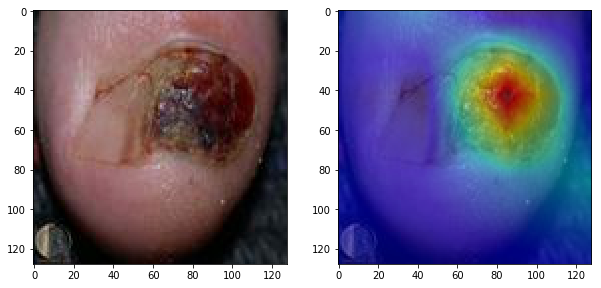

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 10))
# Image without localization
ax[0].imshow((load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255).squeeze())
# Image with localization
CAM = plot_CAM('DATASET/melanoma_resized/melanomaalm14.jpg', ax[1], xception_model, all_amp_layer_weights)
plt.show()

In [93]:
def getting_two_layer_weights_m():
    # The model

    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (128, 128, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    #model.summary()

    # Compiling the model
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    # loading the weights
    model.load_weights('saved_models/weights.best.mobilenet6.hdf5')
    
    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    # Extracting the wanted output
    xception_model = Model(inputs = model.input, outputs = (model.layers[-3].output, model.layers[-1].output))
    
    return xception_model, all_amp_layer_weights

In [94]:
mob_model, all_amp_layer_weights_m= getting_two_layer_weights()

In [95]:
def mob_CAM(img_path, model, all_amp_layer_weights):
    import scipy
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = model.predict(load_img(img_path)) # last_conv_output.shape = (1, 16, 16, 1024)
    
    # Converting the dimension of last convolutional layer to 16 x 16 x 1024     
    last_conv_output = np.squeeze(last_conv_output)
    
    # Model's prediction
    predicted_class = np.argmax(predictions)
    
    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)
    
    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    
    
    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class

In [96]:
final_output, predicted_class = mob_CAM('DATASET/melanoma_resized/melanomaalm14.jpg', mob_model, all_amp_layer_weights)

In [109]:
def plot_CAM_m(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    #im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (512, 512))
    im = load_img(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = mob_CAM(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.5, interpolation='nearest', vmin=0, vmax=1)

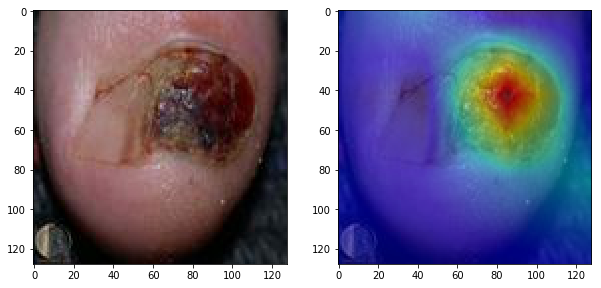

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 10))
# Image without localization
ax[0].imshow((load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255).squeeze())
# Image with localization
CAM = plot_CAM_m('DATASET/melanoma_resized/melanomaalm14.jpg', ax[1], mob_model, all_amp_layer_weights)
plt.show()

In [99]:
def getting_two_layer_weights_r():
    # The model

    # Imprting the model
    from keras.applications.resnet50 import ResNet50

    # Pre-build model
    base_model = ResNet50(include_top = False, weights = None, input_shape = (128, 128, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 5, activation = 'softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    #model.summary()

    # Compiling the model
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    # loading the weights
    model.load_weights('saved_models/weights.best.resnet2.hdf5')
    
    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    # Extracting the wanted output
    xception_model = Model(inputs = model.input, outputs = (model.layers[-3].output, model.layers[-1].output))
    
    return xception_model, all_amp_layer_weights

In [102]:
res_model, all_amp_layer_weights_m= getting_two_layer_weights_r()

/home/abdul/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [103]:
def res_CAM(img_path, model, all_amp_layer_weights):
    import scipy
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = model.predict(load_img(img_path)) # last_conv_output.shape = (1, 16, 16, 1024)
    
    # Converting the dimension of last convolutional layer to 16 x 16 x 1024     
    last_conv_output = np.squeeze(last_conv_output)
    
    # Model's prediction
    predicted_class = np.argmax(predictions)
    
    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)
    
    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    
    
    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class

In [104]:
final_output, predicted_class = res_CAM('DATASET/melanoma_resized/melanomaalm14.jpg', res_model, all_amp_layer_weights)

In [105]:
def plot_CAM_m(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    #im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (512, 512))
    im = load_img(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = res_CAM(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.5, interpolation='nearest', vmin=0, vmax=1)

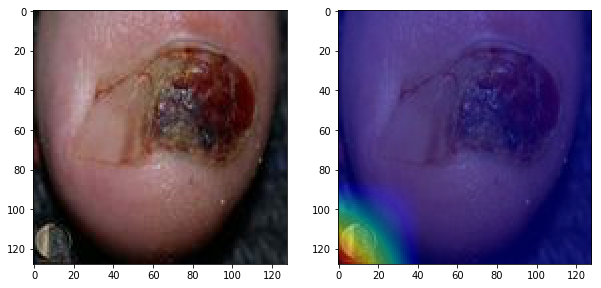

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 10))
# Image without localization
ax[0].imshow((load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255).squeeze())
# Image with localization
CAM = plot_CAM_m('DATASET/melanoma_resized/melanomaalm14.jpg', ax[1], res_model, all_amp_layer_weights)
plt.show()

# Ensemble

In [25]:
def ensemble(models, model_input):
    
    outputs = [model(model_input) for model in models]
    
    y = keras.layers.Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model


In [26]:
from keras.layers import Input
model_input = Input(shape=(128, 128, 3))

In [27]:
models = [mobilenet_model, xception_model,resnet]

In [28]:
ensemble_model = ensemble(models , model_input)

In [29]:
ensemble_model.save('saved_models/weights.best.ensemble2.hdf5')
#2

In [32]:
ensemble_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 5)            3233989     input_5[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 5)            20871725    input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 5)            23597957    input_5[0][0]                    
__________________________________________________________________________________________________
average_1 

In [66]:
image_to_predict = load_img('DATASET/melanoma_resized/melanomaalm14.jpg').astype('float32')/255

In [68]:
pred=ensemble_model.predict(image_to_predict)
print('basal :           ',pred[0][0],"\nSeborrhoeic_keratosis  : ",pred[0][1],
      "\nSolar_lentigo :        ",pred[0][2],"\nSquamous_cell_carcinoma : ",pred[0][3],
      "\nmelanoma  :          ",pred[0][4])

basal :            0.18438326 
Seborrhoeic_keratosis  :  0.02933233 
Solar_lentigo :         0.073821776 
Squamous_cell_carcinoma :  0.008984604 
melanoma  :           0.70347804


In [30]:
pred=ensemble_model.predict(test_imgs)
pred

array([[0.23627262, 0.00170565, 0.00208375, 0.7520463 , 0.00789168],
       [0.02061423, 0.97043216, 0.00153479, 0.00370148, 0.00371734],
       [0.05913953, 0.8872478 , 0.00436539, 0.01250295, 0.03674432],
       ...,
       [0.5538032 , 0.00350425, 0.00138381, 0.42523462, 0.01607421],
       [0.33361384, 0.521657  , 0.03963146, 0.03361674, 0.07148096],
       [0.13754177, 0.59145546, 0.07358856, 0.01291988, 0.18449444]],
      dtype=float32)

In [31]:
def accuracy(true_val,pred_val):
    acc=np.mean(np.equal(np.argmax(test_Y, axis=-1), np.argmax(pred, axis=-1)))
    return acc

In [32]:
print(accuracy(test_Y,pred))

0.7506775067750677
